In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/cifar10

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/cifar10


# LIB

In [ ]:
import tensorflow as tf
import numpy as np                                
import matplotlib.pyplot as plt
import keras as k
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from keras.regularizers import l2
import h5py
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import np_utils

# FUCTION

In [ ]:
def plothist(hist):
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc = 'upper left')
    plt.show()

# DATA

170498071/170498071 [==============================] - 13s 0us/step
[6]
[9]
[9]
[4]
[1]
[1]
[2]
[7]
[8]


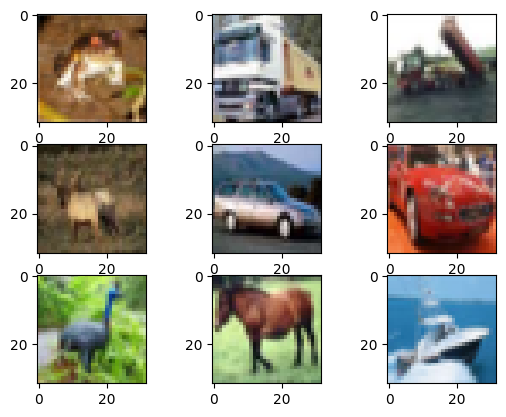

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_rows, img_cols , channels = 32,32,3
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
    print(y_train[i])
plt.show()

In [ ]:
# DATA AUGMENTATION
datagen = ImageDataGenerator(
    rotation_range = 15,
    horizontal_flip = True,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.3
)
datagen.fit(x_train)

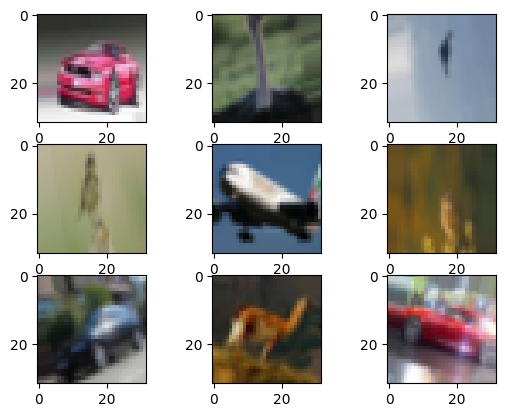

In [ ]:
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break

In [ ]:
# reshape into images
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, 1)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [ ]:
# convert integers to float; normalise and center the mean
x_train = x_train.astype("float32")  
x_test = x_test.astype("float32")
mean = np.mean(x_train)
std=np.std(x_train)
x_test = (x_test-mean)/std
x_train = (x_train-mean)/std

In [ ]:
# labels
num_classes=10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [ ]:
print(x_train.shape)
print(y_train.shape)

(50000, 32, 32, 3)
(50000, 10)


In [ ]:
# val_data
ids = np.random.choice(50000, 10000, replace= False)
idsTrain = [i for i in range(50000) if i not in ids]
idsTrain, ids
x_val = x_train[ids]
y_val = y_train[ids]
x_train = x_train[idsTrain]
y_train = y_train[idsTrain]

# BUILD MODEL

In [ ]:
num_filters = 32
ac = 'relu'
adm = tf.keras.optimizers.legacy.Adam(learning_rate = 0.001, decay = 0, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08)
opt = adm
drop_dense = 0.5
drop_conv = 0.2

model = Sequential()

model.add(Conv2D(num_filters, (3, 3), activation = ac, input_shape=(img_rows, img_cols, channels), padding='same'))
model.add(BatchNormalization(axis = -1))
model.add(Conv2D(num_filters, (3, 3), activation = ac, padding = 'same'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D(pool_size = (2, 2)))   # reduces to 16x16x3xnum_filters
model.add(Dropout(drop_conv))

model.add(Conv2D(2 * num_filters, (3, 3), activation = ac, padding='same'))
model.add(BatchNormalization(axis = -1))
model.add(Conv2D(2 * num_filters, (3, 3), activation = ac, padding='same'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D(pool_size = (2, 2)))   # reduces to 8x8x3x(2*num_filters)
model.add(Dropout(drop_conv))

model.add(Conv2D(4 * num_filters, (3, 3), activation=ac,padding='same'))
model.add(BatchNormalization(axis = -1))
model.add(Conv2D(4 * num_filters, (3, 3), activation=ac,padding='same'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D(pool_size = (2, 2)))   # reduces to 4x4x3x(4*num_filters)
model.add(Dropout(drop_conv))

model.add(Flatten())
model.add(Dense(512, activation = ac))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(num_classes, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = opt)

# TRAIN MODEL

In [ ]:
modelCheckpoint = ModelCheckpoint('cifar10.h5', 
                                   monitor = 'val_accuracy', 
                                   save_best_only = True, 
                                   verbose = 0)

In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size = 128),
                              steps_per_epoch = len(x_train) / 128, epochs = 200, validation_data = (x_val, y_val),
                              callbacks = [modelCheckpoint, EarlyStopping(monitor ='loss', patience = 5)])

Epoch 1/200
312/312 [==============================] - 38s 90ms/step - loss: 1.9396 - accuracy: 0.3700 - val_loss: 1.9840 - val_accuracy: 0.3170
Epoch 2/200
312/312 [==============================] - 28s 89ms/step - loss: 1.4298 - accuracy: 0.4961 - val_loss: 1.1673 - val_accuracy: 0.5815
Epoch 3/200
312/312 [==============================] - 27s 87ms/step - loss: 1.2214 - accuracy: 0.5634 - val_loss: 0.9930 - val_accuracy: 0.6527
Epoch 4/200
312/312 [==============================] - 26s 85ms/step - loss: 1.0770 - accuracy: 0.6184 - val_loss: 0.9930 - val_accuracy: 0.6635
Epoch 5/200
312/312 [==============================] - 27s 86ms/step - loss: 0.9984 - accuracy: 0.6471 - val_loss: 1.0311 - val_accuracy: 0.6644
Epoch 6/200
312/312 [==============================] - 27s 86ms/step - loss: 0.9335 - accuracy: 0.6719 - val_loss: 0.7729 - val_accuracy: 0.7304
Epoch 7/200
312/312 [==============================] - 26s 82ms/step - loss: 0.8786 - accuracy: 0.6921 - val_loss: 0.8013 - val_ac

# SAVE MODEL

In [ ]:
model.save('cifar10.h5')

# MATRIX CONFUSION

313/313 [==============================] - 1s 2ms/step


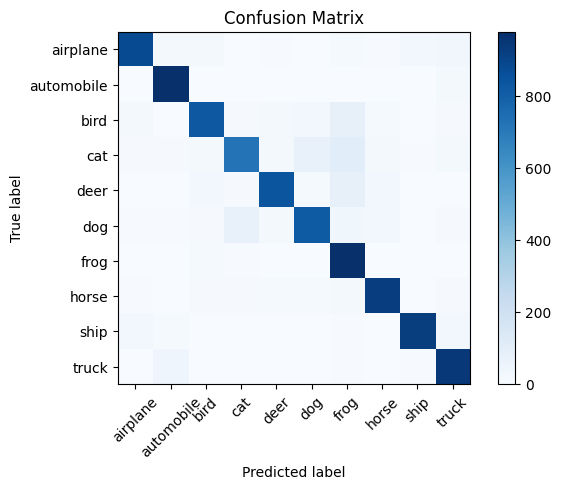

In [ ]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
plt.imshow(confusion_mtx, interpolation = 'nearest', cmap = plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], rotation = 45)
plt.yticks(tick_marks, ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# CHECK MODEL

In [ ]:
model_test_acc  =model.evaluate(x_test, y_test, batch_size = 128)
model_test_acc

79/79 [==============================] - 1s 7ms/step - loss: 0.3882 - accuracy: 0.8812


[0.38823914527893066, 0.8812000155448914]

# LOSS MODEL

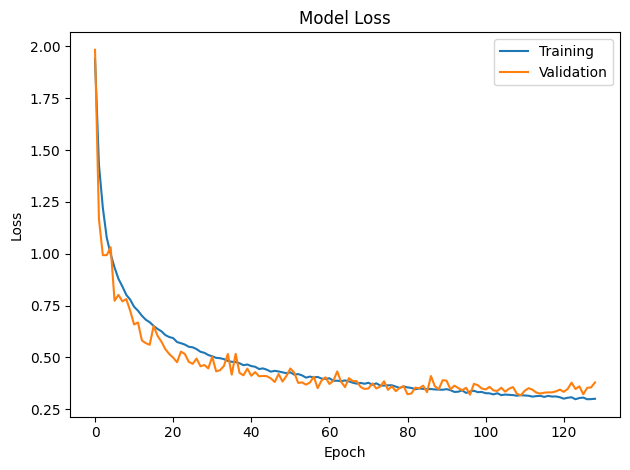

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc = 'upper right')
plt.tight_layout()
plt.show()

# ACCURACY MODEL


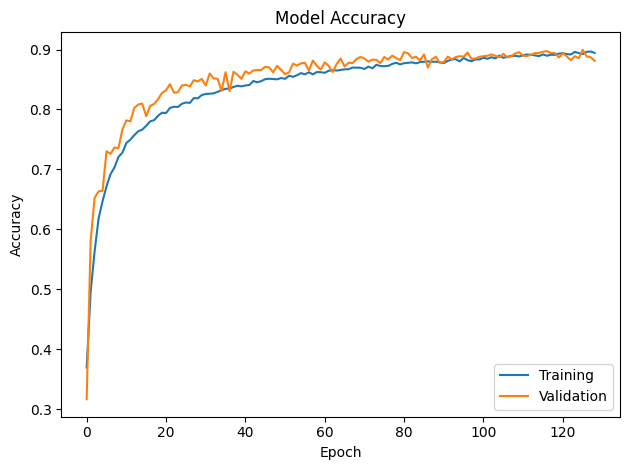

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc = 'lower right')
plt.tight_layout()
plt.show()

# TEST

In [ ]:
import imageio.v2 as imageio
import cv2
import numpy as np
model = tf.keras.models.load_model('cifar10.h5')

In [ ]:
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

TEST 1

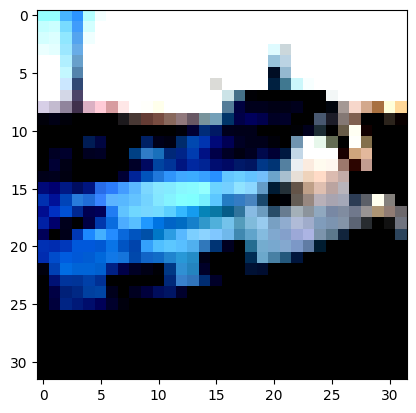

In [ ]:
index = 2
img = x_test[index]
plt.imshow(img)

In [ ]:
img = img.reshape(1,32,32,3)
y_hat = model.predict(img)
classes[np.argmax(y_hat)]

1/1 [==============================] - 0s 371ms/step


'ship'

TEST 2

<ipython-input-23-3d4f7fe4cd99>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('ship1.jpg')


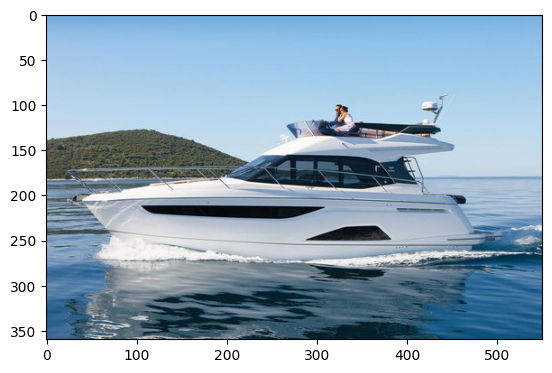

In [ ]:
img = imageio.imread('ship1.jpg')
plt.imshow(img)

(32, 32, 3)


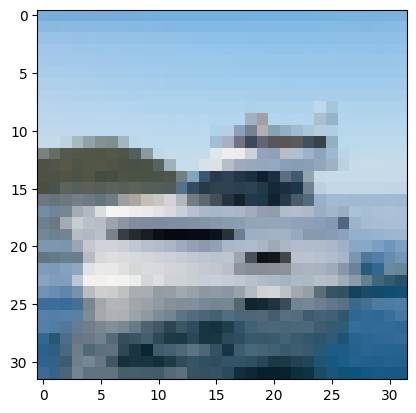

In [ ]:
img = cv2.resize(img, (32,32), interpolation = cv2.INTER_AREA)
print(img.shape)
plt.imshow(img)
img = img.reshape(1, 32, 32, 3)
img = img.astype("float32")  
mean = np.mean(img)
std = np.std(img)
img = (img-mean)/std

In [ ]:
y_hat = model.predict(img)
classes[np.argmax(y_hat)]

1/1 [==============================] - 0s 30ms/step


'ship'

TEST 3

<ipython-input-26-215e0e7f4da5>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('plane1.jpg')


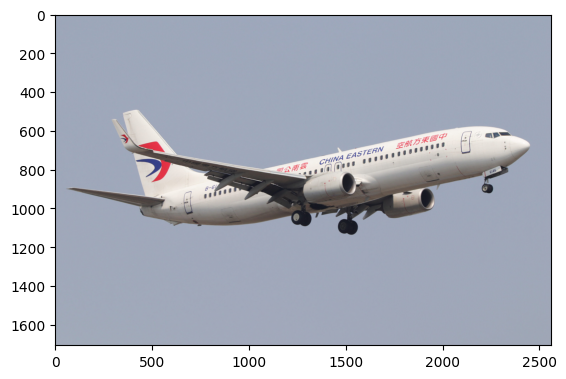

In [ ]:
img = imageio.imread('plane1.jpg')
plt.imshow(img)

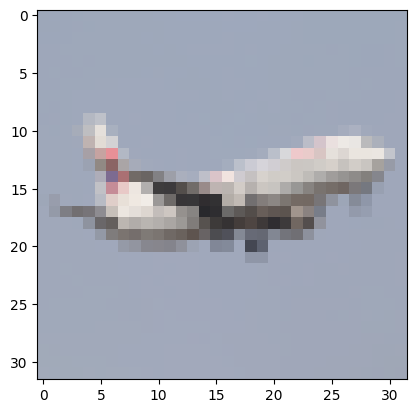

In [ ]:
img = cv2.resize(img, (32,32), interpolation = cv2.INTER_AREA)
plt.imshow(img)
img = img.reshape(1, 32, 32, 3)
img = img.astype("float32")  
mean = np.mean(img)
std = np.std(img)
img = (img-mean)/std

In [ ]:
y_hat = model.predict(img)
classes[np.argmax(y_hat)]

1/1 [==============================] - 0s 18ms/step


'airplane'

TEST 4

<ipython-input-29-f9aacc840a55>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('horse1.jpg')


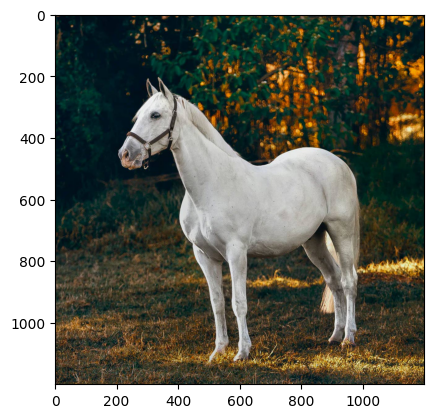

In [ ]:
img = imageio.imread('horse1.jpg')
plt.imshow(img)

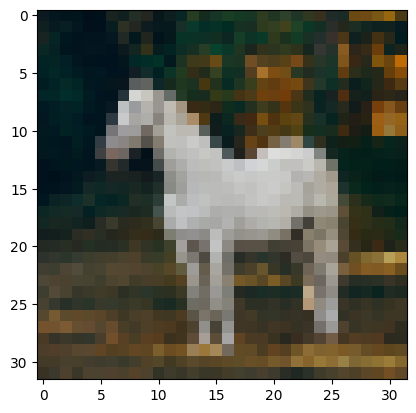

In [ ]:
img = cv2.resize(img, (32,32), interpolation = cv2.INTER_AREA)
plt.imshow(img)
img = img.reshape(1, 32, 32, 3)
img = img.astype("float32")  
mean = np.mean(img)
std = np.std(img)
img = (img-mean)/std

In [ ]:
y_hat = model.predict(img)
classes[np.argmax(y_hat)]

1/1 [==============================] - 0s 19ms/step


'horse'

TEST 5

<ipython-input-32-7d48164e5af6>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('cat1.jpg')


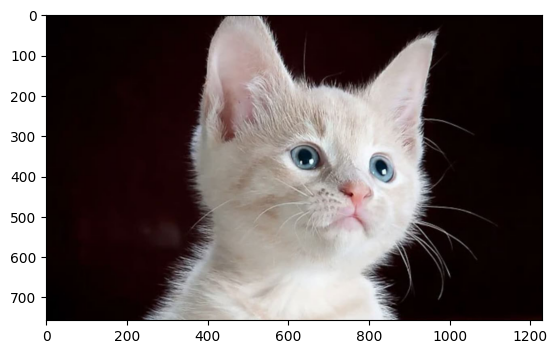

In [ ]:
img = imageio.imread('cat1.jpg')
plt.imshow(img)

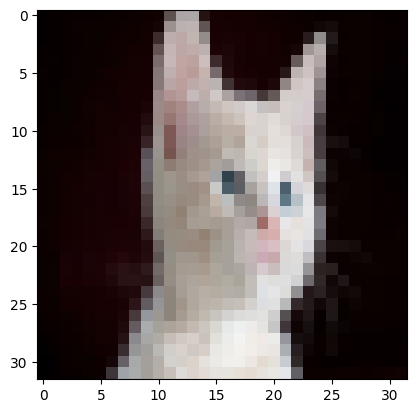

In [ ]:
img = cv2.resize(img, (32,32), interpolation = cv2.INTER_AREA)
plt.imshow(img)
img = img.reshape(1, 32, 32, 3)
img = img.astype("float32")  
mean = np.mean(img)
std = np.std(img)
img = (img-mean)/std

In [ ]:
y_hat = model.predict(img)
classes[np.argmax(y_hat)]

1/1 [==============================] - 0s 22ms/step


'cat'

TEST 6

<ipython-input-35-1549f1cc7dd4>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('automobile1.jpg')


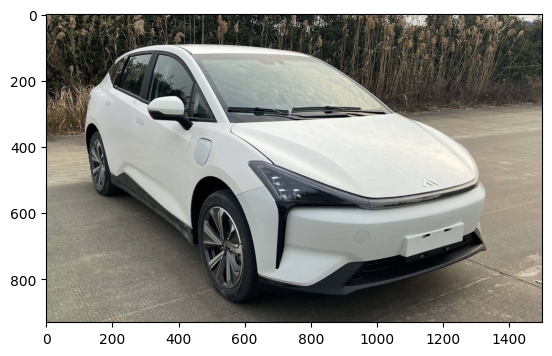

In [ ]:
img = imageio.imread('automobile1.jpg')
plt.imshow(img)

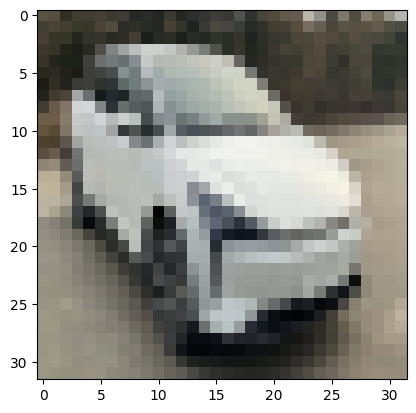

In [ ]:
img = cv2.resize(img, (32,32), interpolation = cv2.INTER_AREA)
plt.imshow(img)
img = img.reshape(1, 32, 32, 3)
img = img.astype("float32")  
mean = np.mean(img)
std = np.std(img)
img = (img-mean)/std

In [ ]:
y_hat = model.predict(img)
classes[np.argmax(y_hat)]

1/1 [==============================] - 0s 19ms/step


'automobile'